# TIME DOMAIN SOLUTION FOR OSCILLATING REACTION NETWORK

In [11]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

# Reaction Network
<img src="Fig1.png" alt="Reaction Network" width="500"/>

# Notation

* ${\bf A}$ constant matrix for linear system
* $\alpha_n$ - amplitude of oscillation for species $n$
* $\Delta$ - $det {\bf A})$
* $i$ - indexes constants
* $k_i$ - positive constant
* $K$ - number of constants
* $\lambda$ - eigenvalue
* $n$ - indexes species
* $N$ - number of species
* $\omega_n$ - offset of species $n$
* $\phi_n$ - phase in radians
* $\tau$ - $tr({\bf A})$
* $\theta$ - frequency in radians
* ${\bf u}$ - forced input (kinetic constants for zeroth order rates)
* ${\bf x}$ ($N \times 1$) is the state vector
* $x_n$ (t) - time varying concentration of species $n$

Linear system
\begin{equation}
\dot{\bf x} = {\bf A} {\bf x} + {\bf u}\label{eq:linear}
\end{equation}

Notes
1. From the foregoing definitions, the oscillating characteristics are $\{\alpha_n, \theta, \phi_n, \omega_n \}$. So, there 7 OCs.
1. The parameters of the network are the $k_i$, $x_n (0)$. So, there are 8 parameters.

The objective here is to design a reaction network that generates oscillations
that can be controlled as to their:
* frequency $\alpha$
* amplitude $H$
* offset (translation) so that the midpoint is $M$
* phase $D$

# Programming Preliminaries

In [2]:
import tellurium as te
import sympy
from sympy import init_printing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import control

init_printing()

In [2]:
TIMES = [0.01*n for n in range(500)]

In [9]:
"""
Old definitions 
S1, S2, k1, k2, k3, k4, d, T, D, r1, r2, a, t, x1_0, x2_0, u1, u2, b1, b2, m1, m2, h1, h2 =   \
   sympy.symbols("S1, S2, k1, k2, k3, k4, D, T, D, r1, r2, a, t, x1_0, x2_0, u1, u2, b1, b2, m1, m2, h1, h2", real=True)
c1, c2 = sympy.symbols("c1, c2")
"""
c1, c2, T, theta, phi, r1, r2, t, b1, b2, m1, m2, h1, h2 =   \
   sympy.symbols("c1, c2, T, theta, phi, r1, r2, t, b1, b2, m1, m2, h1, h2 ", real=True)
c1, c2 = sympy.symbols("c1, c2")
alpha, delta, omega, S1, S2, k1, k2, k3, k4, k5, k6, alpha, x1, x1_0, x2, x2_0 =   \
    sympy.symbols("alpha, delta, omega, S1, S2, k1, k2, k3, k4, k5, k6, alpha, x1, x1_0, x2, x2_0 ", real=True, positive=True)

# Antimony Model of the Oscillating Reaction Network

Below, we construct a simulation model of the reaction network in the Antimony language. The simulation results are used to check steps in the analytical derivations.

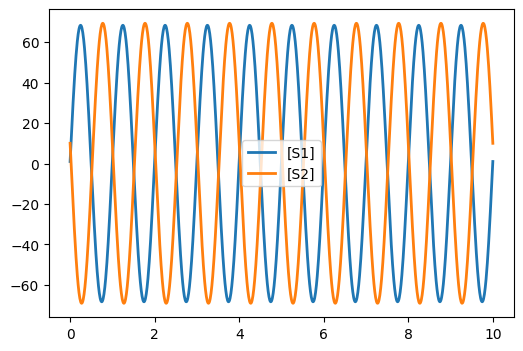

In [42]:
MODEL = """
J1: S1 -> S2; k1*S1
J2: S2 -> S1; k2*S2
J3: S1 -> 2 S1; k3*S1
J4: S1 -> ; k4
J5: S2 -> ; k5*S1
J6: -> S2; k6

# Parameters are assigned programmatically below
k1 = -1
k2 = -1
k3 = -1
k4 = -1
k5 = -1
k6 = -1
# Initial values assigned here
S1 = 1
S2 = 10

"""
rr = te.loada(MODEL)
period = 1
delta = 1 # excess of k5 over k3
frequency_in_time = 1/period
theta = frequency_in_time*2*np.pi
PARAM_DCT = {"k1": 1.0, "theta": theta, "delta": delta, "k4": 5, "k6": 5}
PARAM_DCT["k2"] = theta**2/delta
PARAM_DCT["k3"] = PARAM_DCT["k1"] + PARAM_DCT["k2"]
PARAM_DCT["k5"] = PARAM_DCT["k3"] + delta
PARAM_DCT["x1_0"] = rr["S1"]
PARAM_DCT["x2_0"] = rr["S2"]
ser = pd.Series(PARAM_DCT)
ser = ser.sort_index()
PARAM_DCT = ser.to_dict()
             
"""             
PARAM_DCT["k1"] = PARAM_DCT["k2"] + PARAM_DCT["k4"]
PARAM_DCT["d"] = (frequency_in_radians**2)/PARAM_DCT["k4"]
PARAM_DCT["k3"] = PARAM_DCT["k1"] + PARAM_DCT["d"]
rr = te.loada(MODEL)
names = ["S1", "S2", "u1", "u2"]
"""
for k, v in PARAM_DCT.items():
    if k in rr.keys():
        rr[k] = v
data = rr.simulate(0, 10, 1000)
rr.plot(data)

In [31]:
rr.getFullJacobian()

            S1,       S2
S1 [[  39.4784,  39.4784],
S2  [ -40.4784, -39.4784]]

In [32]:
np.linalg.eigvals(rr.getFullJacobian())

array([7.15919175e-14+6.28318531j, 7.15919175e-14-6.28318531j])

In [43]:
PARAM_DCT

{'delta': 1.0,
 'k1': 1.0,
 'k2': 39.47841760435743,
 'k3': 40.47841760435743,
 'k4': 5.0,
 'k5': 41.47841760435743,
 'k6': 5.0,
 'theta': 6.283185307179586,
 'x1_0': 1.0,
 'x2_0': 10.0}

# Helpers

In [11]:
def pp(arr):
    print(pd.DataFrame(arr))

In [12]:
def makeTimes(start_time=0, end_time=5, point_density=10):
    return [1/point_density*n for n in range(start_time, point_density*end_time+1)]
# TESTS
end_time = 10
point_density = 2
times = makeTimes(end_time=end_time, point_density=point_density)
assert(len(times) == point_density*end_time+1)

In [13]:
# Simulation of the model
def simulateLinearSystem(A=None, B=None, is_plot=True):
    """
    Simulates the linear system specified by A and B
    """
    if A is None:
        A = np.array([ [PARAM_DCT["k1"] - PARAM_DCT["k2"], PARAM_DCT["k4"]],
                           [PARAM_DCT["k2"] - PARAM_DCT["k3"], - PARAM_DCT["k4"] ] ])
    if B is None:
        B = np.eye(2)
    C = np.eye(2)
    D = 0*np.eye(2)
    sys = control.StateSpace(A, B, C, D)
    sys = control.LinearIOSystem(sys, inputs=["S1", "S2"], outputs=["S1", "S2"])
    X0 = [1, 10]
    times = makeTimes(end_time=20)
    response = control.input_output_response(sys, T=times, X0=X0)
    plt.plot(response.t, response.y[0])
    plt.plot(response.t, response.y[1])
    plt.legend(["S1", "S2"], loc="upper left")
    if not is_plot:
        plt.close()
    
# Tests
simulateLinearSystem(is_plot=False)

In [14]:
def simulateSymbol(sym, dct, times=TIMES, is_plot=True):
    """
    Simulates a symbol that is a function of time.
    The time symbol must be "t".
    
    Parameters
    ----------
    sym: sympy.Symbol
    t: sympy.Symbol
    dct: dict (substitutions)
    
    Returns
    -------
    list-float
    """
    # Find the time symbol
    time_syms = [a for a in sym.atoms() if str(a) == "t"]
    if len(time_syms) == 0:
        raise ValueError("No time found!")
    if len(time_syms) > 1:
        raise ValueError("Multiple times found!")
    t = time_syms[0]
    # Simulation of ivp_solution
    new_sym = sym.subs(dct)
    vals = [float(sympy.simplify(new_sym.subs(t, v))) for v in times]
    if is_plot:
        plt.plot(times, vals)
    return vals

values = simulateSymbol(t, {}, is_plot=False)
np.testing.assert_array_equal(values, TIMES)
print("OK!")

OK!


In [15]:
def simulateSymbolVector(vec, dct, is_plot=True):
    """
    Simulates a 2-d vector symbol that is a function of time.
    The time symbol must be "t".
    
    Parameters
    ----------
    sym: sympy.Symbol
    dct: dict (substitutions)
    """
    s1_vals = simulateSymbol(vec[0], dct, times=TIMES)
    s2_vals = simulateSymbol(vec[1], dct, times=TIMES)
    #
    plt.plot(TIMES, s1_vals)
    plt.plot(TIMES, s2_vals)
    _ = plt.legend(["S1", "S2"])
    if not is_plot:
        plt.close()
    
vec = sympy.Matrix([t, t**2])
_ = simulateSymbolVector(vec, {}, is_plot=False)
print("OK!")

OK!


In [16]:
def simulateRR(dct={}, is_plot=True):
    """
    Simulates the model with parameter updates as indicated.
    """
    rr = te.loada(MODEL)
    for key, value in PARAM_DCT.items():
        if key in rr.keys():
            rr[key] = value
    for key, value in dct.items():
        if key in rr.keys():
            rr[key] = value
    data = rr.simulate(0, 5, 1000)
    for col in data.colnames[1:]:
        plt.plot(data[:, 0], data[col])
    plt.legend(data.colnames[1:])
    if not is_plot:
        plt.close()
    
# Tests
simulateRR(is_plot=False)
print("OK!")

OK!


# Solution Details

Let ${\bf A} =
\begin{pmatrix}
a_{11} & a_{12} \\
a_{21} & a_{22} \\
\end{pmatrix}
$
Denote the determinant by $det({\bf A}) = \Delta = a_{11} a_{22} - a_{12} a_{21}$
and the trace by $\tau = tr({\bf A}) = a_{11} + a_{22}$. The eigenvalues are
$\lambda = \frac{1}{2} \left( - \tau \pm \sqrt{\tau^2 - 4 \Delta} \right)$.
So, to get pure imaginary eigenvalues, $\tau = 0$
and $\Delta > 0$.

<img src="Fig1.png" alt="Reaction Network" width="500"/>

## System Equations

In the sequel, we sometimes use $S_n$ to denote $x_n (t)$ to better draw out the connection between the reaction network and the system of differential equations for its solution.

This system equations are:
$
\begin{eqnarray}
\dot{S}_1 & = & - k_1 S_1 + +k_2 S_2 + k_3 S_1 - k_4 \\
\dot{S}_2 & = & k_1 S_1 - k_2 S_2 - k_5 S_1 + k_6  \\
\end{eqnarray}
$

Let ${\bf x} = 
\begin{pmatrix}
S_1 \\
S_2 \\
\end{pmatrix}
$,
$
{\bf A} = 
\begin{pmatrix}
k_3 - k_1 & k_2 \\
k_1 - k_5 & -k_2 \\
\end{pmatrix}
$, and
${\bf u} = 
\begin{pmatrix}
- k_4 \\
k_6  \\
\end{pmatrix}$

The full model is:
$\dot{\bf x} = {\bf A} {\bf x} + {\bf u}$.

Note that
\begin{eqnarray}
T & = & tr(A) = k_1 -k_2 - k_4 \\
D & = & det(A) = (k_1 - k_2)(-k_4) - k_4 (k_2 - k_3) \\
& = & k_4 (k_3 - k_1) \\
\end{eqnarray}

## Jacobian for Pure Imaginary Eigenvalues

The eigenvalues a $2 \times 2$ matrix are

$\lambda = - \frac{T \pm \sqrt{T^2 - 4 D}}{2}$.

The pole $\lambda$ is pure imaginary (i.e., $\sqrt{D}i$) if:
1. $T = 0$. That is, $k_1 = k_2 + k_4$.
1. $D > 0$. That is, $k_3 > k_1$.

$D > 0 \iff k_4(k_3 - k_1) > 0$.
Clearly $k_4 > 0$ since $D>0$, and so we can divide by $k_4$.
So, we have the criteria is $k_3 = k_1 + \delta$ for $\delta >0$.


Note that if $tr({\bf A}) = 0$ and $D >0$:
1. $k_1 = k_2 + k_4$.
1. $k_3 = \delta + k_2 + k_4$, $\delta > 0$.

$
{\bf A} =
\begin{pmatrix}
k_1 - k_2 & k_4 \\
k_2 - k_3 & -k_4 \\
\end{pmatrix}
$.

Substituting,
${\bf A} =
\begin{pmatrix}
k_2 + k_4 - k_2 & k_4 \\
k_2 - \delta - k_2 - k_4 & -k_4 \\
\end{pmatrix}
=
\begin{pmatrix}
k_4 & k_4 \\
-\delta -k_4 & -k_4 \\
\end{pmatrix}
$.

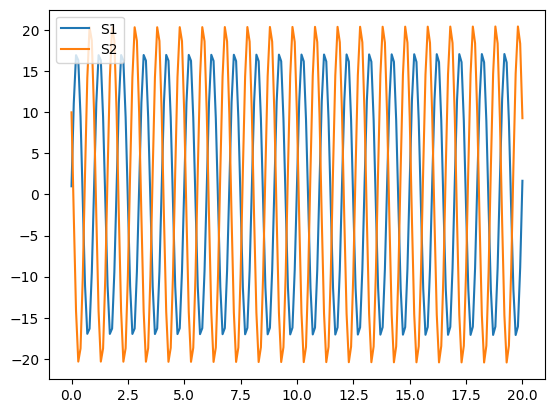

In [17]:
# Validation plot
A = np.array([ [PARAM_DCT["k4"], PARAM_DCT["k4"]],
                           [-PARAM_DCT["d"] - PARAM_DCT["k4"], - PARAM_DCT["k4"] ] ])
simulateLinearSystem(A=A)

In [18]:
# Period requires converting from radians
1/(np.sqrt(PARAM_DCT["d"]*PARAM_DCT["k4"])/(2*np.pi))

## Eigenvectors for Pure Imaginary Eigenvalues

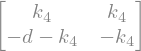

In [19]:

A = sympy.Matrix([ [k4 , k4], [-d-k4, -k4]])
A

Note that since $\delta > 0$, ${\bf A}$ is nonsingular.

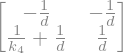

In [20]:
A.inv()

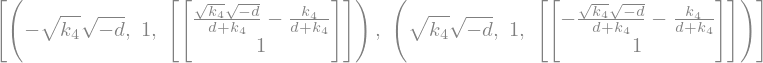

In [21]:
A.eigenvects()

### Validate the eigenvectors

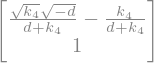

In [22]:
vec = A.eigenvects()[0][2][0]
vec

In [23]:
# First eigenvalue, eigenvector
vec = A.eigenvects()[0][2][0]
sympy.simplify((-sympy.eye(2)*sympy.sqrt(-d *k4) - A)*vec)

In [24]:
# Second eigenvalue, eigenvector
vec = A.eigenvects()[1][2][0]
sympy.simplify((sympy.eye(2)*sympy.sqrt(-d *k4) - A)*vec)

### Format eigenvectors

In [25]:
sympy.pretty_print(A.eigenvects()[0][2][0])
sympy.pretty_print(A.eigenvects()[1][2][0])

⎡  ____   ____         ⎤
⎢╲╱ k₄ ⋅╲╱ -d      k₄  ⎥
⎢───────────── - ──────⎥
⎢    d + k₄      d + k₄⎥
⎢                      ⎥
⎣          1           ⎦
⎡    ____   ____         ⎤
⎢  ╲╱ k₄ ⋅╲╱ -d      k₄  ⎥
⎢- ───────────── - ──────⎥
⎢      d + k₄      d + k₄⎥
⎢                        ⎥
⎣           1            ⎦


The eigenvalues are:

$
\begin{eqnarray}
\lambda_1 &=& - \sqrt{\delta k_4} i \\
\lambda_2 &=&  + \sqrt{\delta k_4} i
\end{eqnarray}
$

We define $\alpha = \sqrt{\delta k_4}$, and so
$\lambda_n = (-1)^n \alpha i$.

The eigenvectors are:

$
\begin{eqnarray}
{\bf e}_1 & = &
\left[\begin{matrix}- \frac{k_{4}}{\delta + k_{4}} - \frac{\alpha i}{\delta + k_{4}}\\1\end{matrix}\right] \\
{\bf e}_2 & = &
\left[\begin{matrix} - \frac{k_{4}}{\delta + k_{4}} + \frac{\alpha i}{d + k_{4}}\\1\end{matrix}\right] \\
\end{eqnarray}
$

## Fundamental Matrix (${\bf F}$)

The fundamental matrix ${\bf F}$ is a marix with columns that are orthogonal solutions to the homogeneous system.

If the eigenvalue ${\bf w}$ and/or
vector $\lambda$ are complex, then
${\bf w} e^{\lambda} = {\bf v}_1 + i {\bf v}_2$ for
some real vectors ${\bf v}_n$.
By theorem, the ${\bf v}_n$ are independent solutions to
the differential equation
and so the solution to the IVP
is $\sum_{n=1}^2 c_n v_n$ for $c_n$ chosen
based on the initial values.
Hence, ${\bf F} =
\left[ \begin{matrix} {\bf v}_1 & {\bf v}_2 \\ \end{matrix} \right]$.

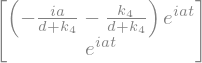

In [26]:
# Construct one eigenvector for the homogeneous IVP solution
w_vec = sympy.Matrix([ [-k4/(k4 + d) - a/(d + k4)*I], [1]])*(sympy.exp(I*a*t))
w_vec

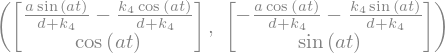

In [27]:
vecs = w_vec.as_real_imag()
vecs

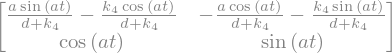

In [28]:
FUND_MAT = sympy.Matrix([ [vecs[0][0], vecs[1][0]], [vecs[0][1], vecs[1][1]]])
FUND_MAT  # Fundamental matrix

${\bf F} = \left[\begin{matrix}\frac{a \sin{\left(a t \right)}}{d + k_{4}} 
                 - \frac{k_{4} \cos{\left(a t \right)}}{d + k_{4}} & 
                 - \frac{a \cos{\left(a t \right)}}{d + k_{4}} - \frac{k_{4} \sin{\left(a t \right)}}{d 
                + k_{4}}\\\cos{\left(a t \right)} & \sin{\left(a t \right)}\end{matrix}\right]$



## Solution for Nonhomogeneous System

The equation with forced inputs is $\dot{\bf x} = {\bf A} {\bf x} + {\bf u}$,
where ${\bf u}$ is the forced input.
The solution with forced inputs has the form
${\bf x}^H + {\bf x}^P$, where ${\bf x}^H$
is a solution to the homogeneous system and ${\bf x}^P$ is a particular solution
for the forced input ${\bf u}$.

Recall the following for solutions of nonhomogeneous systems.
Let ${\bf F}$ be the fundamental matrix for $\dot{\bf x} = {\bf A} {\bf x} + {\bf u}$.
We want to construct a particular solution
${\bf x}^P = {\bf F} {\bf v}$, for the unknown vector ${\bf v}$.

Substituting,

\begin{eqnarray}
\dot{\bf F} {\bf v} + {\bf F} \dot{\bf v} & = & {\bf A} {\bf F} {\bf v} + {\bf u} \\
{\bf A} {\bf F} {\bf v} + {\bf F} \dot{\bf v} & = & {\bf A} {\bf F} {\bf v} + {\bf u} \\
{\bf F} \dot{\bf v} & = & {\bf u} \\
{\bf v} = \int \left( {\bf F}^{-1} {\bf u} \right)dt
\end{eqnarray}

Note that there is an integration constant as well, but this need not be considered
since all values of the constant still result in a valid particular solution.
Also, the inverse exists since the columns of ${\bf X}_F$ are orthogonal.

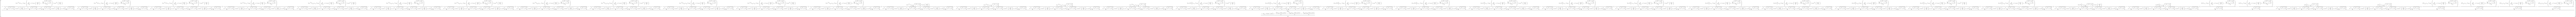

In [29]:
rhs = sympy.simplify(FUND_MAT.inv()*sympy.Matrix([[u1], [u2]]))
rhs = sympy.integrate(rhs, t)
rhs

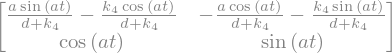

In [30]:
FUND_MAT

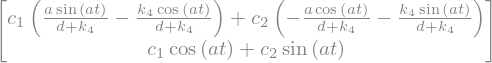

In [31]:
xhh = FUND_MAT*sympy.Matrix([[c1], [c2]])
xhh

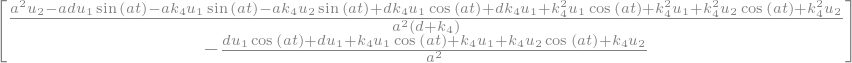

In [32]:
xp = sympy.simplify(FUND_MAT*rhs)
xp

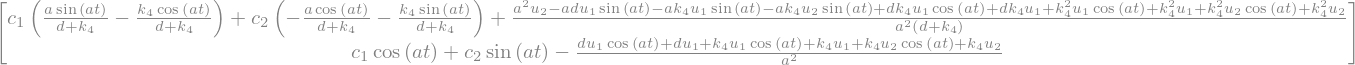

In [33]:
nonh_solution = xhh + xp
nonh_solution

In [34]:
cdct = sympy.solve(nonh_solution.subs(t, 0) - sympy.Matrix([ [x1_0], [x2_0]]), [c1, c2])

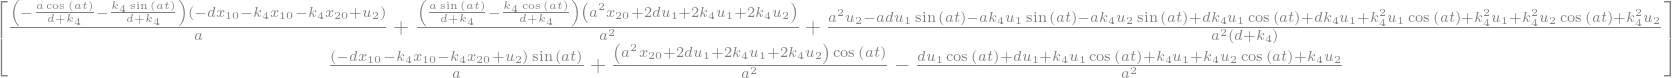

In [35]:
nonh_solution = nonh_solution.subs(cdct)
nonh_solution

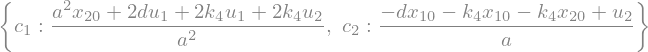

In [36]:
cdct

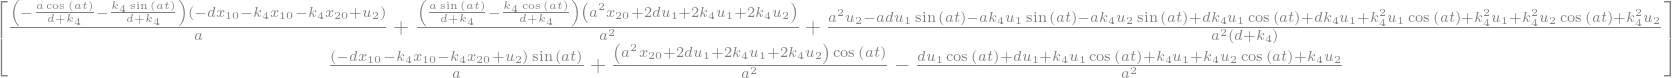

In [37]:
nonh_solution

In [38]:
def makeSymbolDct(expression, name_dct, exclude_names=None):
    """
    Creates a dictionary whose keys are symbols in the expression with the same name.
    """
    if exclude_names is None:
        exclude_names = []
    convert_dct = {s.n: s for s in expression.free_symbols}
    dct = {}
    for sym in convert_dct.values():
        if sym.name in exclude_names:
            continue
        if not sym.name in name_dct.keys():
            raise ValueError("Cannot find symbol with name %s" % sym.name)
        dct[sym] = name_dct[sym.name]
    #
    return dct
# Tests
name_dct = dict(PARAM_DCT)
name_dct["x1_0"] = 0
name_dct["x2_0"] = 0
name_dct["t"] = 3
makeSymbolDct(nonh_solution_subs, name_dct, exclude_names=["t"])
                            

NameError: name 'nonh_solution_subs' is not defined

In [ ]:
nonh_solution_subs.free_symbols

In [ ]:
name_dct = dict(PARAM_DCT)
name_dct["x1_0"] = 1
name_dct["x2_0"] = 1
name_dct["u_1"] = 1
name_dct["u_2"] = 1
name_dct

In [ ]:
SYMBOL_DCT = makeSymbolDct(nonh_solution, name_dct, exclude_names=["t"])
SYMBOL_DCT.update(cdct)
SYMBOL_DCT

In [ ]:

nonh_solution_subs = nonh_solution.subs(SYMBOL_DCT).subs(SYMBOL_DCT)
nonh_solution_subs

In [ ]:
result1 = simulateSymbolVector(nonh_solution_subs, [])

In [ ]:
rr.plot(data)

# Designing an Oscillator

The parameters of the oscillator are:
* kinetics parameters: $k_4$, $\delta$ (which then determine $k_1$, $k_3$, and $k_2$ doesn't matter)
* initial conditions for species: $x_n (0)$, $n \in \{1, 2\}$
* forced inputs: $u_1, u_2$

Given a desired frequency $\alpha$, amplitude $h_1, h_2$, and
midpoint $m_1, m_2$, find values of the parameters that achieve this.

$r_1 = \frac{k_4}{k_4 + \delta}$
and $r_2 = \frac{\alpha}{\delta + k_4}$,
where $\alpha = \sqrt{\delta k_4}$.

A key fact is that a linear combination of sinusoids at the same frequency is also a sinusoid 
at the same frequency but with a phase displacement and a new amplitude.

Let $y = a \times cos(\alpha) + b \times sin(\alpha)$.
Let $A = \sqrt{a^2 + b^2}$ and 
$D = arctan(\frac{b}{a})$.
Then $y = A \times cos(\alpha - D)$.

In [ ]:
dct = {r1: k4/(k4 + d), r2: a/ (d + k4)}
xf = sympy.simplify(nonh_solution.subs(dct).subs(dct))
#xf = sympy.simplify(nonh_solution.subs({sympy.cos(a*t): -sympy.sin(a*t)}))

In [ ]:
def removeFactor(sym, factor_str):
    """
    Removes any of the symbolic factors
    """
    result = 1
    for tt in sym.args:
        if not factor_str in str(tt):
            result *= tt
    return result

def separateTerms(sym):
    """
    Separates the terms in a scalar expression into:
        constants
        coefficient of sin(at)
        coefficient of cost(at)
    """
    constants = []
    sints = []
    costs = []
    # Partition the entire expression of a sum of multiplied terms
    for term in sym.expand().args:
        if "cos(" in str(term):
            costs.append(removeFactor(term, "cos"))
        elif "sin(" in str(term):
            sints.append(removeFactor(term, "sin"))
        else:
            constants.append(term)
    return constants, sints, costs

def sumTerms(terms):
    result = 0
    for term in terms:
        result += term
    return sympy.simplify(result)

def calcCoefficients(sym):
    """
    Calculates the coefficients for the constant, sin, and cos terms
    """
    constants, sints, costs = separateTerms(sym)
    return sumTerms(constants), sumTerms(sints), sumTerms(costs)

def getCosine(sym):
    terms = sym.expand().args
    for term in terms:
        if "cos(" in str(term):
            for element in term.args:
                if "cos(" in str(element):
                    return element
            

def refactorSinusoids(sym):
    """
    Combines linear combinations of cos and sin into a single term.
    """
    cos_arg = getCosine(sym).args[0]
    constant, coef_sin, coef_cos = calcCoefficients(sym)
    amplitude = sympy.sqrt(coef_sin**2 + coef_cos**2)
    phase = sympy.atan(coef_sin/coef_cos)
    offset = sympy.Piecewise((0, coef_cos >= 0), (sympy.pi, coef_cos < 0))
    result = constant + amplitude*sympy.cos(cos_arg - phase + offset)
    return result
    

# TESTS
#sym = xf.expand()[0]
#constants, sints, costs = separateTerms(sym)
#const_term, sin_term, cos_term = calcCoefficients(sym)
xf1 = refactorSinusoids(xf.expand()[0])
xf2 = refactorSinusoids(xf.expand()[1])
refactor_vec = sympy.Matrix([xf1, xf2])
            
            
            

**TO DO**
1. Simplify the following.

In [ ]:
refactor_vec

In [ ]:
sym = simulateSymbolVector(refactor_vec, SYMBOL_DCT)

In [ ]:
simulateRR(DCT)

**TO DO**
1. Validate by resimulating
1. Approximate for low and high frequency

Proceed by considering the cases of small $\alpha$ and large $\alpha$.

In [ ]:
angles = 2*np.pi*np.array(range(20))*1/20
cost = np.cos(angles)
sint = np.sin(angles)
sin_shift = np.sin(np.pi/2+angles)
plt.scatter(angles, cost, color="red")
plt.scatter(angles, sint, color="green")
plt.plot(angles, sin_shift, color="black")
plt.legend(["cos", "sin", "sin shift"])

In [ ]:
angles = 2*np.pi*np.array(range(40))*1/20
a1 = 2
a2 = 3
cost = a1*np.cos(angles)
sint = a2*np.sin(angles)
new_a = np.sqrt(a1**2 + a2**2)
new_d = np.arctan(a2/a1)
new_cos = new_a*np.cos(angles - new_d)
plt.scatter(angles, cost+sint)
plt.plot(angles, new_cos)

In [ ]:
DCT

In [ ]:
simulateSymbolVector(xf, DCT)

In [ ]:
simulateRR(DCT)

## Solutions

In [ ]:
xf1 = xf[0]
xf2 = xf[1]

In [ ]:
xf1

In [ ]:
xf2

In [ ]:
eqns = [m1 - (𝑘4*(𝑑+𝑘4)*(𝑢1+𝑢2)), a - sympy.sqrt(d*k4),
       h1 - sympy.Max(a**2, k4*(𝑘4*20 - 𝑢2+ 𝑥1_0*(𝑑+𝑘4)), 
                     a**2/(d*k4*(d + k4)), k4*(𝑘4*𝑥2_0 - 
                                               𝑢2+𝑥1_0*(𝑑+𝑘4))/(d*k4*(d + k4)))]
eqns

In [ ]:
design_solutions = {a: sympy.sqrt(d*k4),
                    h1: sympy.Max( 
                                  sympy.Abs(((a**2)*x1_0 + x2_0*a**2 + d*u1)/(a*d)),
                                  sympy.Abs(-u1 -u2 + x1_0)/d + x1_0/d),
                    m1: a*u1-a*u2,
                    h2: sympy.Max(
                        sympy.Abs(-a*𝑘4*𝑥2_0 - a*𝑥1_0*(𝑑+𝑘4)+𝑢2*𝑑*𝑘4)/(a**2),
                        
                        sympy.Abs((a*𝑥2_0*d*𝑘4+𝑘4*u2+u1*(d+𝑘4)))/(a**2)
                    ),
                    m2: -k4*u2-u1*(d+k4)/a**2
                                  }

In [ ]:
design_solutions[a]

# Notes
1. Develop the idea of a UMRA approximation to a non-linear network.
  1. For mas action networks with two reactants, create two separate uni-reactant reactions. How select the kinetics constants in the approximation to most accurate estimate the original network. The kinetics constants can be approximated using a Taylor's series or by an orthogonal projection for an appropriately defined inner product space.

1. Note that the eigenvalues are ${\bf e} = \{ \lambda |  det \left( {\bf A} - \lambda {\bf I} \right) = 0 \}$.
Since ${\bf A} = {\bf H} + {\bf K}$,
$ {\bf A} - \lambda {\bf I}  = {\bf H} + {\bf K} - \lambda {\bf I}$.

1. Note that $det \left( {\bf A} - \lambda {\bf I} \right)
= \left( {\bf N V} - \lambda {\bf I} \right)$.
Further, $det \left( {\bf N} - \lambda {\bf I} \right) \left(
 {\bf V} - \lambda {\bf I} \right)$
 $= det \left[ {\bf N}{\bf V} - \lambda {\bf N} - \lambda {\bf V} + I \right]$. Can I use information about the [sum of determinants](https://www.geeksforgeeks.org/eigen-values-and-eigen-vectors/) to figure out
 how $\lambda$ changes if $k_m$ changes?

1. From ["Facts about Eigenvalues"](https://www.adelaide.edu.au/mathslearning/ua/media/120/evalue-magic-tricks-handout.pdf), I know that for a polynomial function $g(x)$, $g({\bf A})$ has eigenvalues $g(\lambda_1), \cdots, g(\lambda_n)$ for the matrix ${\bf A}$ with eigenvalues $\lambda_1, \cdots, \lambda_n$.
So, it's easy to transform ${\bf A}$ in a way that preserves
UMRN so that the dominant eigenvalue is at 0 by subtracting along
the diagonal.
The challenge is making the this eigenvalue have a non-zero imaginary component.

1. Note that in the decomposition into Hermitian and skew Hermitian matrices ${\bf A} = {\bf H} + {\bf K}$, the diagonal of ${\bf K}$ must be zero if ${\bf A}$ is real valued.
So, how can ${\bf K}$ be transformed to create imaginary eigenvalues?

1. Might consider using the polar decomposition, where ${\bf A} = {\bf U} {\bf P}$, where ${\bf U}$ is unitary and ${\bf P}$ is positiv semidefinite. My hypothesis is that if ${\bf U}$ is a rotation other than $n \pi$, then ${\bf A}$ has at least one imaginary eigenvalue. I still have the challenge of making the *dominant* eigenvalue have a non-zero imaginary part.

1. Try exploring matrices and their decompositions to understand the criteria for obtaining eigenvalues with a non-zero imaginary part.

1. **Issue**: Not getting the correct period


# Other Oscilators

In [ ]:
# Evolved oscillator
r = te.loada ('''
var S0
var S1
ext S2
S1 -> S1+S1; k0*S1
S1 + S0 -> S0 + S0; k1*S1*S0
S0 -> ; k2*S0
k0 = 54
k1 = 22
k2 = 340
S0 = 1.0
S1 = 5.0
S2 = 9.0
''')
m = r.simulate (0, 0.5, 400)
r.plot()

In [ ]:
model = """
// Oscillator (Heinrich model)
// From the review:
// Metabolic Regulation and Mathematical Models
// R.HEINRICH, S.M.RAPOPORT, T.A.RAPOPORT
// In Progress in Biophysics and Molecular Biology
// 1977, Vol 32, p1-82

// Reactions:
J0: $X0 -> S1; v0
J1: S1 -> ; k3*S1
J2: S1 -> S2; (k1*S1 - k_1*S2)*(1 + c*S2^q)
J3: S2 ->; k2*S2

// Species initializations
S1 = 0; S2 = 1; X0 = 1

// Variable initializations
v0 = 8; k3 = 0
k1 = 1; k_1 = 0
c = 1;  q = 3
k2 = 5;
"""
rr = te.loada(model)
rr.simulate(0, 20)
rr.plot()

# Save

The homogeneous system is $\dot{\bf x} = {\bf A} {\bf x}$.
Consider
Its solution has the for
${\bf x}(t) = \sum _{n=1}^2 c_n {\bf e}_n e^{\lambda_n t}$.

The homogeneous system is $\dot{\bf x} = {\bf A} {\bf x}$.
Its solution has the for
${\bf x}(t) = \sum _{n=1}^2 c_n {\bf e}_n e^{\lambda_n t}$.

Note that $e^{\pm \alpha i } = cos(\alpha ) \pm i sin(\alpha )$.
In the following, $\alpha = \sqrt{\delta k_4}$.
So

$
\begin{eqnarray}
{\bf x} (t) & = & c_1 {\bf e}_1 e^{\lambda_1 t} + c_2 {\bf e}_2 e^{\lambda_2 t} \\
& = & c_1 {\bf e}_1 \left[ cos (\alpha t) - i sin(\alpha t) \right] 
+ c_2 {\bf e}_2 [ cos (\alpha t) + i sin(\alpha t) ]  \\
& = &
c_1 \left[\begin{matrix} - \frac{k_{4}}{\delta - k_{4}} [cos(\alpha) - i sin(\alpha)]  -
\frac{\alpha i}{d + k_{4}}[cos(\alpha) - i sin(\alpha)]\\
cos(\alpha) - i sin(\alpha)
\end{matrix}\right] +
c_2 \left[\begin{matrix} - \frac{k_{4}}{\delta + k_{4}} [cos(\alpha) + i sin(\alpha)]  + \frac{\alpha i}{d + k_{4}}[cos(\alpha) + i sin(\alpha)]\\
cos(\alpha) + i sin(\alpha)
\end{matrix}\right] \\
& = &
2c \left[ \begin{matrix} -\frac{k_4}{\delta + k_4}cos(\alpha t) -\frac{\alpha}{\delta + k_4}sin(\alpha t) \\
  cos(\alpha t)
\end{matrix} \right]
\end{eqnarray}
$.

There is no solution that is consistent with the assumption that the
eigenvalues are pure imaginary.
Note that in order to get real values for the solution, we must have $c_1 = c = c_2$.
So, $c = \frac{x_2(0)}{2}$.
But $c = -\frac{x_1(0) [k_4 + \delta]}{2 k_4}$.

Make this into a sum of real and imaginary values.
$
\begin{eqnarray}
& = &
 \left[\begin{matrix} - \frac{k_{4}}{\delta - k_{4}} [c_1 + c_2] cos(\alpha) +
\frac{\alpha i}{d + k_{4}}[c_2 - c_1]\\
c_1 + c_2
\end{matrix}\right]  \\
& ~~ + &
 \left[\begin{matrix} - \frac{k_{4}}{\delta - k_{4}} [- c_1 + c_2]  +
\frac{\alpha i}{d + k_{4}}[c_2 + c_1]\\
- c_1 + c_2
\end{matrix}\right] i sin(\alpha) 
\end{eqnarray}
$.


Let $r_1 = \frac{k_4}{k_4 + \delta}$
and $r_2 = \frac{\alpha}{\delta + k_4}$,
where $\alpha = \sqrt{\delta k_4}$.

Given $r_1, r_2, \alpha$, find $k_4, \delta, \alpha$

$k_4 = \frac{\alpha^2}{\delta}$

\begin{eqnarray}
\delta & =&  \frac{\frac{\alpha^2}{\delta} - r_1 \frac{\alpha^2}{\delta}}{r_1}\\
& = & \sqrt{\frac{\alpha^2 - r_1 \alpha^2}{r_1}}\\
\end{eqnarray}

\begin{eqnarray}
k_4 & =&  \frac{\alpha^2}{\sqrt{\frac{\alpha^2 - r_1 \alpha^2}{r_1}}} \\
& =&  \sqrt{\frac{r_1}{1 - r_1 }} \\
\end{eqnarray}

\begin{eqnarray}
\alpha & =&  r_2 (\delta + k_4) \\
\end{eqnarray}